# Self-organizing maps

Let's take a look at `sklearn-som`: https://github.com/rileypsmith/sklearn-som

This is going to be a toy example -- I'm not going to use very useful attributes.

## Load some seismic data

We'll use 1000 ms of the F3 seismic dataset (CC BY-SA TNO and dGB Earth Sciences). Note this dataset is 16-bit integers. It seems to work okay with `sklearn-som`.

In [1]:
import numpy as np
import segyio

ds = np.DataSource('.')  # <- Local target.

url = 'https://geocomp.s3.amazonaws.com/data/F3_16-bit_int.sgy'

with segyio.open(ds.open(url).name) as s:
    seismic = segyio.cube(s)
    
seismic.shape

(651, 951, 251)

In [2]:
ma = np.percentile(seismic, 99.95)

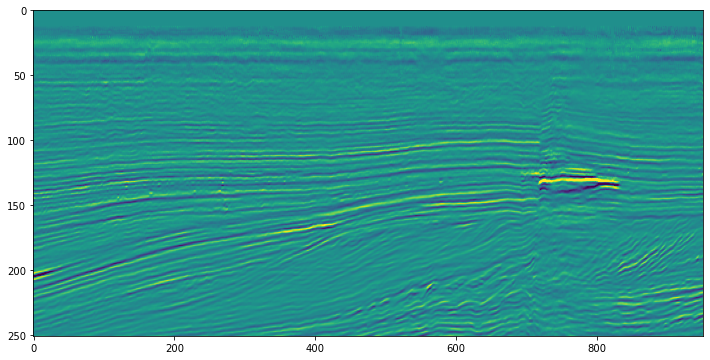

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(seismic[100].T, aspect='auto', vmin=-ma, vmax=ma)

In [4]:
seismic.dtype

dtype('int16')

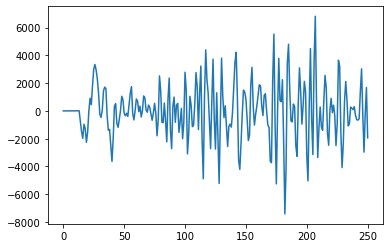

In [5]:
plt.plot(seismic[100, 200])

## Put into `xarray.DataArray`

In [6]:
import xarray as xr

il, xl, ts = seismic.shape

inlines = np.arange(il)
xlines = np.arange(xl)
tslices = 0.004 * np.arange(ts)

da = xr.DataArray(seismic,
                  name='amplitude',
                  coords=[inlines, xlines, tslices],
                  dims=['iline','xline', 'time'],
                 )

In [7]:
da

<xarray.DataArray 'amplitude' (iline: 651, xline: 951, time: 251)>
array([[[    0,     0,     0, ...,  2115,  4235,  -130],
        [    0,     0,     0, ...,   666,  3874,   811],
        [    0,     0,     0, ...,  1050,  3079,   -85],
        ...,
        [    0,     0,     0, ...,  -366,   417, -1233],
        [    0,     0,     0, ...,   243,   947,  -363],
        [    0,     0,     0, ...,   405,   885,  -624]],

       [[    0,     0,     0, ...,  -311,  4306,  1774],
        [    0,     0,     0, ...,   -41,  3017,  1154],
        [    0,     0,     0, ...,  1149,  3126,  -385],
        ...,
        [    0,     0,     0, ...,  -580,   428,  -409],
        [    0,     0,     0, ..., -1106,    71,  -165],
        [    0,     0,     0, ...,  -131,   789,  -397]],

       [[    0,     0,     0, ...,   540,  3467,   883],
        [    0,     0,     0, ...,   187,  2399,  1054],
        [    0,     0,     0, ...,  1773,  3079,  -422],
        ...,
...
        ...,
        [    0,     0,   -28, ..., -1178,    42,  2248],
        [    0,     0,     9, ...,  -664,    42,  1755],
        [    0,     0,   208, ...,    14,  -619,   748]],

       [[    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        ...,
        [    0,     0,   -28, ..., -1786,  -815,  1285],
        [  -91,   -91,  -227, ...,  -783,  -991,  1264],
        [    0,     0,   -71, ...,  -245,  -807,   300]],

       [[    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        ...,
        [  320,   320,   138, ..., -1438, -1053,  1641],
        [  181,   181,  -156, ...,  -459,    30,  1339],
        [   73,    73,   -42, ...,  -201,  -228,  1331]]], dtype=int16)
Coordinates:
  * iline    (iline) int64 0 1 2 3 4 5 6 7 8 ... 643 644 645 646 647 648 649 650
  * xline    (xline) int64 0 1 2 3 4 5 6 7 8 ... 943 944 945 946 947 948 949 950
  * time     (time) float64 0.0 0.004 0.008 0.012 ... 0.988 0.992 0.996 1.0

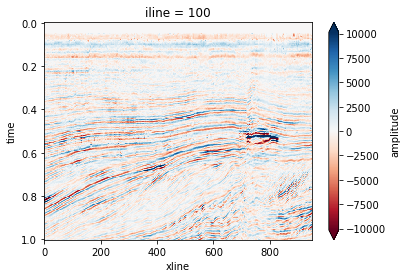

In [8]:
da.loc[100].T.plot.imshow(origin='upper', vmin=-ma, vmax=ma, cmap='RdBu')

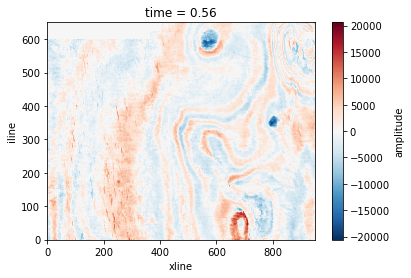

In [9]:
da.loc[:, :, 0.56].plot()

## Define a subcube

Let's keep things simple to start.

In [10]:
s = da.sel(iline=slice(None, 200, 2), xline=slice(600, None, 2), time=slice(0.2, 0.8, 2))
s

<xarray.DataArray 'amplitude' (iline: 101, xline: 176, time: 76)>
array([[[ -200,  3529, -4158, ...,  -794,  -915,  -430],
        [ 1404,  1052,   934, ..., -1400,     0,  -162],
        [-3639,   359, -1052, ..., -2032,  1088, -1140],
        ...,
        [    0,     0,     0, ...,  2248, -3176,  1887],
        [    0,     0,     0, ..., -3457,  -995,  1478],
        [    0,     0,     0, ..., -1273,  -427,  3383]],

       [[-1935,  1553,  -607, ...,  -322,  -456,  -907],
        [-1431,  1553,    -1, ..., -1194,   387,  -883],
        [  272,  1581,  -406, ..., -1721,   783, -1140],
        ...,
        [  785, -1262,  3058, ...,   245, -1276,  1887],
        [ -245, -1611,  3949, ..., -2782, -1334,  2600],
        [ -245,  -756,   824, ...,   509, -2074,  4073]],

       [[-1731,  -454,  1345, ..., -1036,   -90, -1137],
        [-1758,    99,  1214, ..., -1564,    33,  -847],
        [-1068,    61,  1405, ..., -1464,  -120,  -337],
        ...,
...
        ...,
        [ -709,  1146,   102, ...,  -785,  1503, -5015],
        [ -137,  1529,   140, ...,   317,  -256, -3261],
        [ -495,   155,  1674, ...,  1796, -2044, -2061]],

       [[ -100,   -25,  -664, ...,  1513,   931,  -484],
        [  -30,   220,  -706, ...,  1719,   570,  -534],
        [  375,   206,  -545, ...,   248,   924,  -229],
        ...,
        [ -508,   887,   424, ...,   517,   364, -4067],
        [ -137,   832,   700, ...,  1616, -1866, -2333],
        [-1960,  1076,  2301, ...,  3034, -3226, -1638]],

       [[ -200,  -221,  -296, ...,  2233,   263,  -577],
        [ -393,    22,  -344, ...,  1485,   342,  -546],
        [ -719,   -80,  -573, ...,    91,  1025,   111],
        ...,
        [  270,  1031,   869, ...,  1061,  -890, -2604],
        [  152,  1034,   957, ...,  1941, -2537, -1801],
        [ 1265,  2697,   510, ...,  1657, -3179,  -222]]], dtype=int16)
Coordinates:
  * iline    (iline) int64 0 2 4 6 8 10 12 14 ... 188 190 192 194 196 198 200
  * xline    (xline) int64 600 602 604 606 608 610 ... 940 942 944 946 948 950
  * time     (time) float64 0.2 0.208 0.216 0.224 ... 0.776 0.784 0.792 0.8

In [11]:
s.shape

(101, 176, 76)

## Make another attribute

Let's make the quadrature trace.

In [12]:
from bruges.attribute import quadrature

h = quadrature(s)

## Make X

For the input we need a 2D array, with one row per seismic sample and one column per feature (one for amplitude, one for quadrature).

In [13]:
X = np.stack([s.values.ravel(), h.ravel()]).T

## SOM

In [14]:
from sklearn_som.som import SOM

Now, just like with any classifier right from sklearn, we will have to build an SOM instance and call .fit() on our data to fit the SOM.

In [15]:
som = SOM(m=3, n=3, dim=2)
som.fit(X)

In [16]:
y_pred = som.predict(X)

In [17]:
facies = y_pred.reshape(s.shape)
facies.shape

(101, 176, 76)

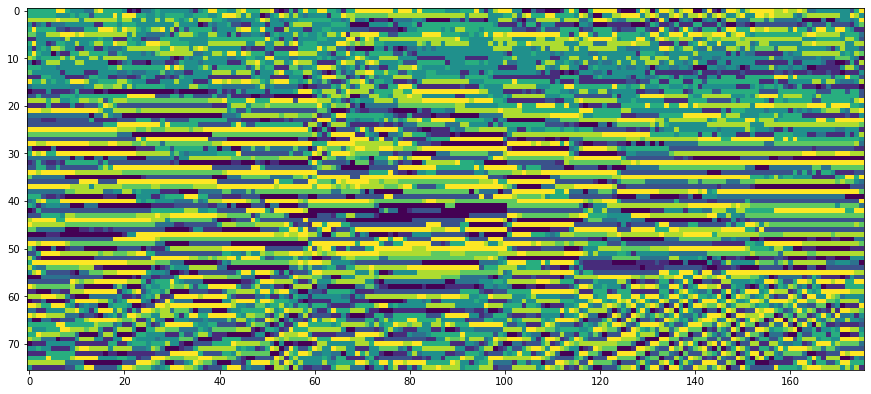

In [18]:
plt.figure(figsize=(15, 9))
plt.imshow(facies[50].T)

In [19]:
np.unique(facies)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

## Make `facies` into `DataArray`

In [20]:
fda = xr.DataArray(facies,
                   name='facies',
                   coords=s.coords,
                   dims=s.dims,
                  )

## Horizon slice

Load a horizon and turn it into an `xarray` DataArray.

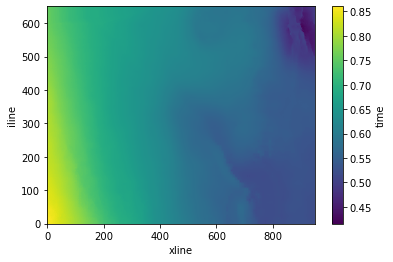

In [21]:
url = "https://geocomp.s3.amazonaws.com/data/F3_horizon.npy"
ds = np.DataSource('.')
horizon = np.load(ds.open(url, mode='rb'))

hda = xr.DataArray(horizon,
                   name='time',
                   coords=[inlines, xlines],
                   dims=['iline','xline'],
                  )

hda.plot()

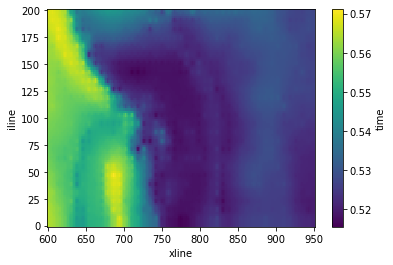

In [22]:
h = hda.sel(iline=slice(None, 200, 2), xline=slice(600, None, 2), )

h.plot()

That looks a bit weird, but I'm not going to worry about it right now.

We can use the horizon to 'slice' into the time axis of the facies DataArray.

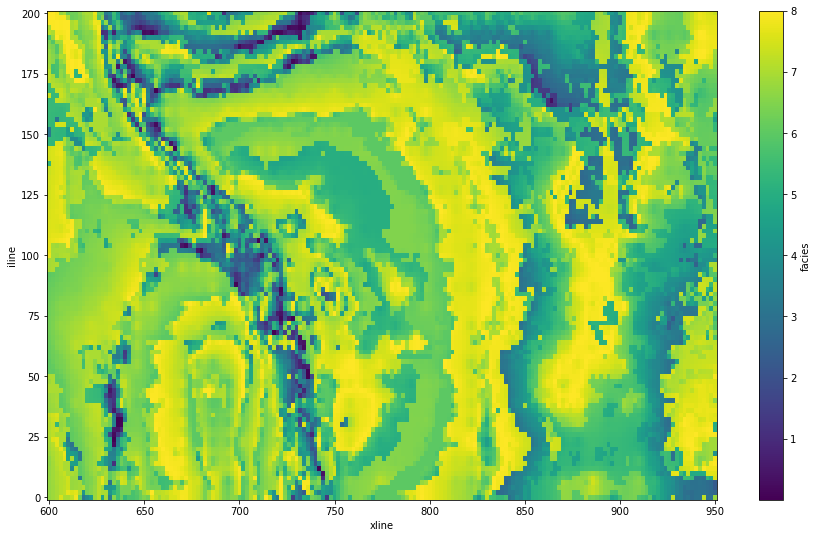

In [23]:
plt.figure(figsize=(15, 9))
fda.interp(time=h).plot()